In [360]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from tqdm import tqdm

In [362]:
from src.neuron_population import NeuronPopulation
from src.connectome import Connectome
from src.overhead import Simulation
from src.neuron_templates import neuron_type_IZ
from src.network_grower import *
from src.network_generators import *
from src.neuron_type_distributor import *
from src.network_weight_distributor import *
from src.external_inputs import *

In [363]:
weight_scale = 1.0
g = 1.2984752590298583 * 60

J_I = weight_scale * g
J_E = weight_scale
delay_mean_E = 10.0
delay_std_E = delay_mean_E * 0.5
delay_mean_I = 1.5
delay_std_I = delay_mean_I * 0.2
v_ext = 0.45527031369449

excitatory_type = "ss4"
inhibitory_type = "b"

In [364]:
seed = 1234

## Generate network

In [365]:
n_neurons = 500

compartment_names = ["in", "out"]

normalize_target_out_E = 15.0
normalize_target_out_I = 750.0

compartment_params = {
    "in": {"type_fractions": {"ss4": 0.8, "b": 0.2}, 
           "inhibitory_types": ("b",), 
           "p0_by_pair": {"EE": 0.5, "EI": 0.5, "IE": 0.5, "II": 0.5},
           "mu_E": 1.0, "sigma_E": 1.6, "mu_I": 30.0, "sigma_I": 6.0,
           "lambda_by_preclass": {"E": 0.2, "I": 0.05},
           "weight_dist_by_ntype": {"ss4": "lognormal", "b": "normal"},
           "outdegree_config_by_type": {
                "ss4": {"dist": "lognormal", "params": (2.65, 0.8)},
                "b":   {"dist": "neg-bin", "params": (50, 40)},
            },
           "normalize_mode": "out",
           "normalize_target_out_E": normalize_target_out_E,
           "normalize_target_out_I": normalize_target_out_I,
           "weight_clip": (1e-4, 100.0),
           "distance_scale": 20.0,
    },
    
    
    "out": {"type_fractions": {"ss4": 0.8, "b": 0.2}, 
           "inhibitory_types": ("b",), 
           "p0_by_pair": {"EE": 0.5, "EI": 0.5, "IE": 0.5, "II": 0.5}, 
           "mu_E": 1.0, "sigma_E": 1.6, "mu_I": 30.0, "sigma_I": 6.0,
           "lambda_by_preclass": {"E": 0.2, "I": 0.05},
           "weight_dist_by_ntype": {"ss4": "lognormal", "b": "normal"},
           "outdegree_config_by_type": {
                "ss4": {"dist": "lognormal", "params": (2.65, 0.8)},
                "b":   {"dist": "neg-bin", "params": (50, 40)},
            },
           "normalize_mode": "out",
           "normalize_target_out_E": normalize_target_out_E,
           "normalize_target_out_I": normalize_target_out_I,
           "weight_clip": (1e-4, 100.0),
           "distance_scale": 20.0,
    },
}

inter_distance_scale = 10.0
compartment_distribution = {"in": 0.5, "out": 0.5}

inter_compartment_matrix=[[0, 0.01],
                          [0.005, 0]]

inter_weight_pair_scale = {"EE": 25.0, "EI": 25.0, "IE": 25.0, "II": 25.0}

# compartment_distance_matrix=[[0.0, inter_distance_scale],
#                              [inter_distance_scale, 0.0]]



G = generate_multi_compartment_spatial_ei_network(
    n_total_neurons=n_neurons,
    compartment_names=compartment_names,
    compartment_params=compartment_params,
    compartment_distribution=compartment_distribution,
    inter_distance_scale=inter_distance_scale,
    inter_compartment_matrix=inter_compartment_matrix,
    inter_weight_pair_scale=inter_weight_pair_scale,
    # compartment_distance_matrix=compartment_distance_matrix,

)

Text(0.5, 1.0, 'b Weight Distribution after Lognormal Redistribution')

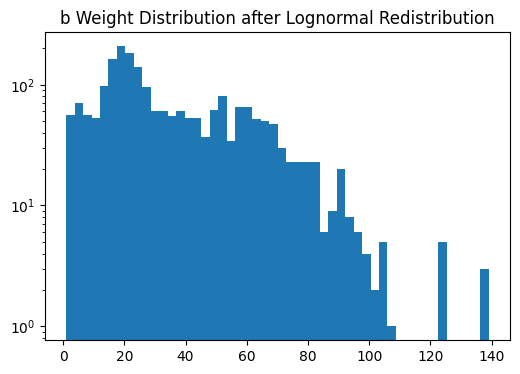

In [366]:
# Plot ss4 weight distribution
n_test_type = "b"
weights = [G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['ntype'] == n_test_type]
plt.figure(figsize=(6,4))
plt.hist(weights, bins=50, log=True)
plt.title(f"{n_test_type} Weight Distribution after Lognormal Redistribution")

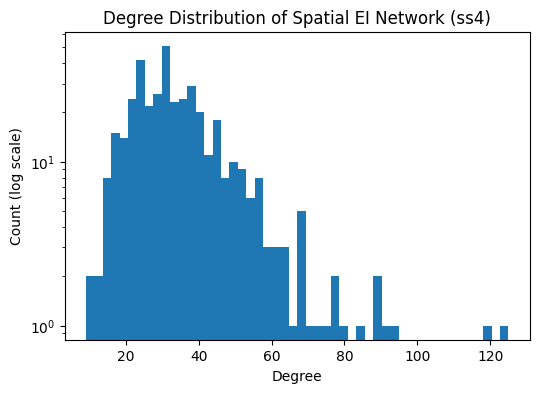

In [367]:
# Plot degree distribution
n_type_show = "ss4"
degrees = [G.degree(n) for n in G.nodes() if G.nodes[n]['ntype'] == n_type_show]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=50, log=True)
plt.title(f"Degree Distribution of Spatial EI Network ({n_type_show})")
plt.xlabel("Degree")
plt.ylabel("Count (log scale)")
plt.show()

In [368]:
enable_plot = False

if enable_plot:
    # Plot graph G using "pos" attribute for node positions
    pos = nx.get_node_attributes(G, 'pos')
    # Edge thinckness proportional to weight
    edges = G.edges()
    weights = [G[u][v]['weight'] / 200.0 for u, v in edges]
    # Node size proportional to degree
    degrees = [G.degree(n) for n in G.nodes()]
    # Node color by neuron type
    ntypes = nx.get_node_attributes(G, 'ntype')
    # Map neuron types to colors
    color_map = {'ss4': 'blue', 'b': 'red'}
    node_colors = [color_map.get(ntypes[n], 'gray') for n in G.nodes()]
    # Edge alpha
    alphas = [0.2 + 0.8 * G[u][v]['weight'] / 10.0 for u, v in edges]
    plt.figure(figsize=(8,8))
    nx.draw(G, pos, node_size=degrees, width=weights, edge_cmap=plt.cm.viridis, node_color=node_colors, alpha=0.65, with_labels=False)
    plt.title("Spatial EI Network Visualization")
    plt.show()

Total inter-compartment weight: 5245.47
Total intra-compartment weight: 81000.00


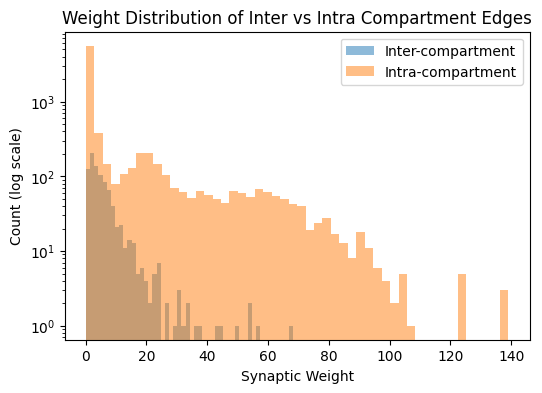

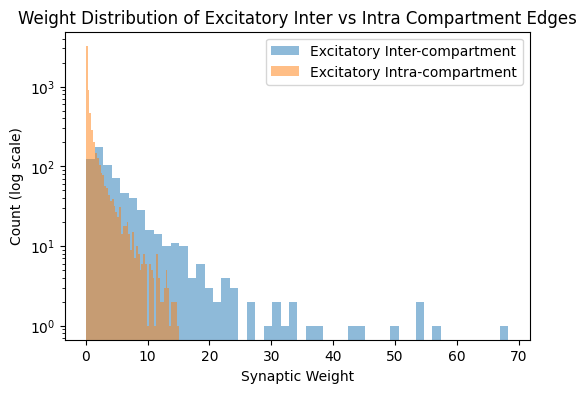

In [369]:
# Weight distribution of edges between compartments
inter_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] != G.nodes[v]['compartment']}
intra_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == G.nodes[v]['compartment']}

# Total sum
total_inter_weight = sum(inter_compartment_edges.values())
total_intra_weight = sum(intra_compartment_edges.values())
print(f"Total inter-compartment weight: {total_inter_weight:.2f}")
print(f"Total intra-compartment weight: {total_intra_weight:.2f}")

# Plot distribution of inter vs intra compartment weights
plt.figure(figsize=(6,4))
plt.hist(list(inter_compartment_edges.values()), bins=50, alpha=0.5, label='Inter-compartment', log=True)
plt.hist(list(intra_compartment_edges.values()), bins=50, alpha=0.5, label='Intra-compartment', log=True)
plt.title("Weight Distribution of Inter vs Intra Compartment Edges")
plt.xlabel("Synaptic Weight")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

# Plot where the presynaptic neurons are only exctiatory
exc_inter_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] != G.nodes[v]['compartment'] and G.nodes[u]['ntype'] == 'ss4'}
exc_intra_compartment_edges = {(u, v): G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == G.nodes[v]['compartment'] and G.nodes[u]['ntype'] == 'ss4'}
plt.figure(figsize=(6,4))
plt.hist(list(exc_inter_compartment_edges.values()), bins=50, alpha=0.5, label='Excitatory Inter-compartment', log=True)
plt.hist(list(exc_intra_compartment_edges.values()), bins=50, alpha=0.5, label='Excitatory Intra-compartment', log=True)
plt.title("Weight Distribution of Excitatory Inter vs Intra Compartment Edges")
plt.xlabel("Synaptic Weight")
plt.ylabel("Count (log scale)")
plt.legend()
plt.show()

In [370]:
# Total sum of weights going from "in" compartment to "out" compartment
total_weight_in_to_out = sum(G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == 'in' and G.nodes[v]['compartment'] == 'out')
print(f"Total weight from 'in' to 'out': {total_weight_in_to_out:.2f}")

# Total sum of weights going from "out" compartment to "in" compartment
total_weight_out_to_in = sum(G[u][v]['weight'] for u, v in G.edges() if G.nodes[u]['compartment'] == 'out' and G.nodes[v]['compartment'] == 'in')
print(f"Total weight from 'out' to 'in': {total_weight_out_to_in:.2f}")

Total weight from 'in' to 'out': 3423.63
Total weight from 'out' to 'in': 1821.84


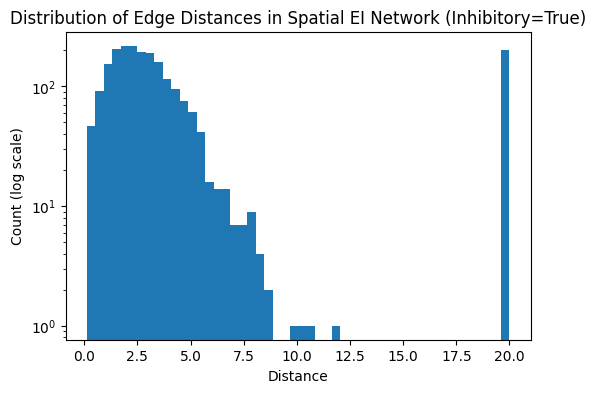

In [371]:
# Print distribution of "distance" attribute for edges
if_inhibitory = True
distances = [G[u][v]['distance'] for u, v in G.edges() if G.nodes[u]['inhibitory'] == if_inhibitory]
plt.figure(figsize=(6,4))
plt.hist(distances, bins=50, log=True)
plt.title(f"Distribution of Edge Distances in Spatial EI Network (Inhibitory={if_inhibitory})")
plt.xlabel("Distance")
plt.ylabel("Count (log scale)")
plt.show()

## Simulation setup

In [372]:
dt = 0.1

In [373]:
# Neuron population parameters
n_neurons = G.number_of_nodes()
neuron_types = [excitatory_type, inhibitory_type]
n_neuron_types = len(neuron_types)
inhibitory = [False, True]
threshold_decay = np.exp(-dt / 5)

pop = NeuronPopulation(n_neurons, neuron_types, inhibitory, threshold_decay)

In [374]:
# Connectome
# Max number of outgoing synapses per neuron
max_synapses = max(dict(G.out_degree()).values())

connectome = Connectome(max_synapses, pop)

connectome.nx_to_connectome(G)

In [375]:
nmda_weight = np.ones(connectome.neuron_population.n_neurons, dtype=float)
nmda_weight[pop.inhibitory_mask.astype(bool)] = 0.959685703507305 * 0.5
# Invert to make excitatory neurons have NMDA weight 1, inhibitory 0
# nmda_weight

In [376]:
connectome.compute_metrics(small_world=False)

{'spectral_radius': 326.4976873541075,
 'n_nodes': 500,
 'n_edges': 9036,
 'n_E': 400,
 'n_I': 100,
 'k_in_mean': 18.072,
 'k_out_mean': 18.072,
 's_in_mean': 172.49094220245846,
 's_out_mean': 172.49094220245846,
 'k_in_std': 5.60800458548865,
 'k_out_std': 12.88000796624058,
 's_in_std': 93.65421348764896,
 's_out_std': 296.0956963787053,
 'edge_frac_EE': 0.6135458167330677,
 'edge_frac_EI': 0.14873837981407703,
 'edge_frac_IE': 0.18902169101372288,
 'edge_frac_II': 0.04869411243913236,
 'reciprocity': 0.17884019477644975,
 'assort_out_to_in_degree': 0.023624666001201534,
 'assort_outStrength_to_inStrength': 0.17987204926686015,
 'clustering_avg_weighted': 0.009561832389365303,
 'transitivity_unweighted': 0.19050690055462402,
 'rich_club_phi_k': 0.19056429232192415,
 'rich_club_k_sel': 47,
 'triadic_census': {'003': 16894122,
  '012': 3200464,
  '102': 349949,
  '021D': 71079,
  '021U': 46919,
  '021C': 84998,
  '111D': 15937,
  '111U': 24116,
  '030T': 10225,
  '030C': 1714,
  '201'

## Find output neurons

In [384]:
# Choose top 20 % of neurons by out-degree in compartment "out"
out_degrees = dict(G.out_degree())
top_neurons_out = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_out if G.nodes[n]['compartment'] == 'out' and G.nodes[n]['ntype'] == 'ss4']
top_neurons_out = compartment_out_neurons[:int(0.2 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_out)
length_top_neurons_out = len(top_neurons_out)
print(f"Top 20% of excitatory neurons by out-degree in 'out' compartment: {length_top_neurons_out} neurons")
# Check neuron types of top neurons
top_neuron_types = [G.nodes[n]['ntype'] for n in top_neurons_out]
type_counts = Counter(top_neuron_types)
print("Neuron type distribution among top neurons:")
for ntype, count in type_counts.items():
    print(f"  {ntype}: {count} neurons")

Top 20% of excitatory neurons by out-degree in 'out' compartment: 40 neurons
Neuron type distribution among top neurons:
  ss4: 40 neurons


## Find input neurons

In [385]:
# Choose top 20 % of neurons by out-degree in compartment "in"
out_degrees = dict(G.out_degree())
top_neurons_in = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_in if G.nodes[n]['compartment'] == 'in' and G.nodes[n]['ntype'] == 'ss4']
top_neurons_in = compartment_out_neurons[:int(0.2 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_in)
length_top_neurons_in = len(top_neurons_in)
print(f"Top 20% of excitatory neurons by out-degree in 'in' compartment: {length_top_neurons_in} neurons")
# Check neuron types of top neurons
top_neuron_types = [G.nodes[n]['ntype'] for n in top_neurons_in]
type_counts = Counter(top_neuron_types)
print("Neuron type distribution among top neurons:")
for ntype, count in type_counts.items():
    print(f"  {ntype}: {count} neurons")

Top 20% of excitatory neurons by out-degree in 'in' compartment: 40 neurons
Neuron type distribution among top neurons:
  ss4: 40 neurons


In [390]:
input_neurons_1 = top_neurons_in[int(0.5 * len(top_neurons_in)):]
input_neurons_2 = top_neurons_in[:int(0.5 * len(top_neurons_in))]

input_1_mask = np.zeros(n_neurons, dtype=bool)
input_2_mask = np.zeros(n_neurons, dtype=bool)

input_1_mask[input_neurons_1] = True
input_2_mask[input_neurons_2] = True

## Find plastic neurons

In [ ]:
# Choose top 10 % of neurons by out-degree in compartment "in"
out_degrees = dict(G.out_degree())
top_neurons_plastic = sorted(out_degrees, key=out_degrees.get, reverse=True)
compartment_out_neurons = [n for n in top_neurons_plastic if G.nodes[n]['ntype'] == 'ss4']
top_neurons_plastic = compartment_out_neurons[:int(0.1 * len(compartment_out_neurons))]
# Shuffle top neurons to avoid any ordering effects
random.shuffle(top_neurons_plastic)
length_top_neurons_plastic = len(top_neurons_plastic)
print(f"Top 20% of excitatory neurons by out-degree for plasticity: {length_top_neurons_plastic} neurons")
# Check compartment distribution of top neurons
compartment_counts = Counter(G.nodes[n]['compartment'] for n in top_neurons_plastic)
print("Compartment distribution among top neurons:")
for compartment, count in compartment_counts.items():
    print(f"  {compartment}: {count} neurons")

Top 20% of excitatory neurons by out-degree for plasticity: 40 neurons
Compartment distribution among top neurons:
  out: 19 neurons
  in: 21 neurons


## Simulation

In [ ]:
dt = 0.1

In [ ]:
def sim_w_input(sim, sim_len_ms, input_mask, input_rate, input_amp):
    poisson = PoissonInput(n_neurons, rate=input_rate * input_mask, amplitude=input_amp)
    steps = int(sim_len_ms / dt)
    for _ in tqdm(range(steps)):
        sim.step(spike_ext=poisson(dt))

100%|██████████| 25000/25000 [00:05<00:00, 4591.69it/s]


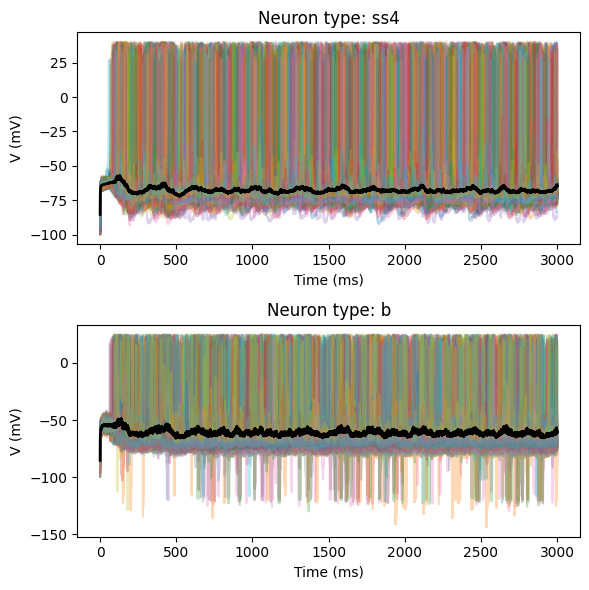

c:\Users\kingt\anaconda3\envs\neuro\Lib\site-packages\numpy\_core\_methods.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\kingt\anaconda3\envs\neuro\Lib\site-packages\numpy\_core\_methods.py:219: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\kingt\Dropbox\Programming\NeuralSimV3\NeuroSimV3\python\src\overhead.py:173: RuntimeWarning: invalid value encountered in divide
  fanos = np.where(mu > 0, var / mu, np.nan)


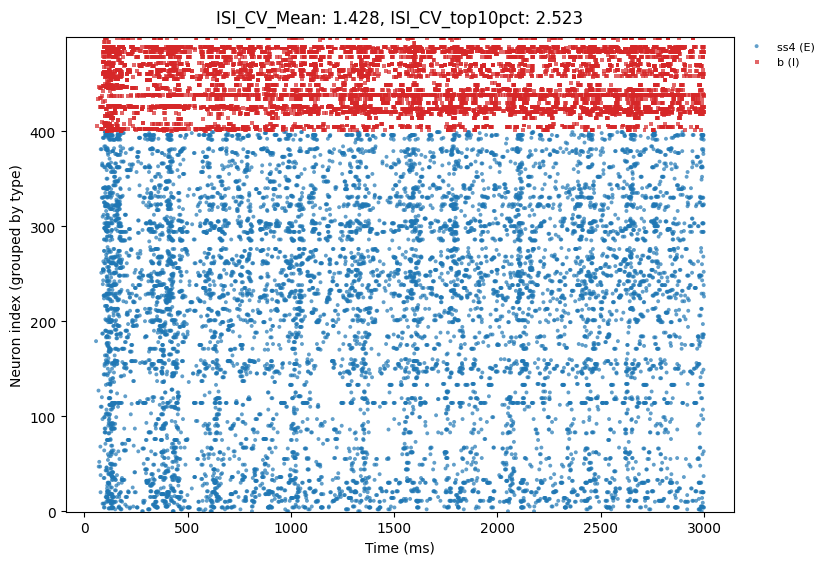

In [ ]:

# Randomize initial voltages
Vs = rng.uniform(-100, -70, size=n_neurons)
us = rng.uniform(0, 400, size=n_neurons)
spikes = np.zeros(n_neurons, dtype=bool)
Ts = np.zeros_like(spikes)

state0 = (Vs,
          us,
          spikes.copy(),
          Ts.copy())

# sim = Simulation(connectome, dt, stepper_type="simple", state0=state0,
#                  enable_plasticity=False)
sim = Simulation(connectome, dt, stepper_type="euler_det", state0=state0,
                 enable_plasticity=False, synapse_kwargs={"LT_scale": 1.0, "NMDA_weight": nmda_weight}, synapse_type="standard",
                 enable_debug_logger=True)

sim.configure_output_readout(output_neuron_indices=top_neurons_out, output_dim=2, rate_window_ms=200.0)

# rate = np.zeros(n_neurons)
poisson = PoissonInput(n_neurons, rate=v_ext, amplitude=2.44625509556019 * 0.25)

output_rates = []

for i in tqdm(range(5000)):
    sensory_spikes = poisson(dt)
    sensory_spikes[pop.inhibitory_mask.astype(bool)] = False
    sim.step(spike_ext=sensory_spikes)
    output_rates.append(sim.read_output_vector())
    # sim.step()

for i in tqdm(range(25000)):
    sim.step()
    output_rates.append(sim.read_output_vector())

sim.plot_voltage_per_type(figsize=(6, 6))

stats = sim.stats.compute_metrics(dt, bin_ms_participation=300)

isi_mean = stats['ISI_CV_mean']
isi_top = stats["ISI_CV_mean_top10pct"]

sim.plot_spike_raster(figsize=(10, 6), title=f"ISI_CV_Mean: {isi_mean:.3f}, ISI_CV_top10pct: {isi_top:.3f}", t_start_ms=0.0, t_stop_ms=9000.0)

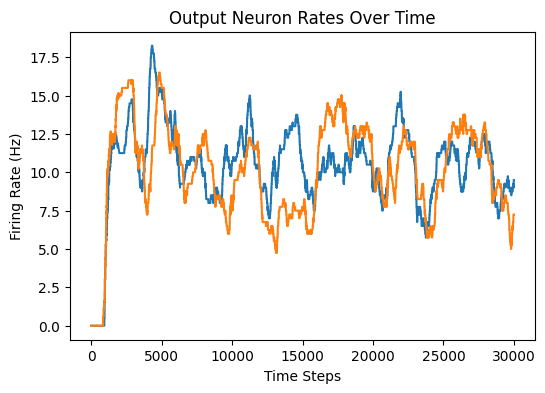

In [379]:
output_rates = np.array(output_rates)
plt.figure(figsize=(6,4))
plt.plot(output_rates)
plt.title("Output Neuron Rates Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Firing Rate (Hz)")
plt.show()

In [380]:
sim.stats.compute_metrics(dt, bin_ms_participation=300, t_start_ms=500.0, t_stop_ms=2500.0)

{'rate_mean_Hz': 13.329333533323332,
 'rate_median_Hz': 3.9998000099994995,
 'rate_p95_Hz': 53.12234388280574,
 'rate_mean_Hz_E': 8.574571271436428,
 'rate_mean_Hz_I': 32.34838258087095,
 'rate_mean_Hz_E_active2spk': 12.305140138676517,
 'rate_mean_Hz_I_active2spk': 62.1507386169153,
 'ISI_CV_median': 1.2818163252142027,
 'ISI_CV_mean': 1.3178874001415528,
 'ISI_CV_mean_E': 1.2487561188539347,
 'ISI_CV_mean_I': 1.6759874372114143,
 'ISI_CV_mean_top10pct': 2.16173866450222,
 'refractory_violations_per_neuron': 1.864,
 'Fano_median_2ms': 0.9919919919919864,
 'Fano_median_10ms': 1.45520153961296,
 'Fano_median_50ms': 1.6324786324786351,
 'Fano_median_100ms': 1.4385964912280702,
 'Fano_median_300ms': 1.0000000000000002,
 'Fano_median_500ms': 1.2372372372372373,
 'Fano_median_1000ms': 1.3095238095238095,
 'mean_noise_corr_2ms': 0.0014122664056948244,
 'mean_noise_corr_10ms': 0.004355231888141355,
 'mean_noise_corr_50ms': 0.014624811700277303,
 'mean_noise_corr_100ms': 0.0159308197307213,
 '

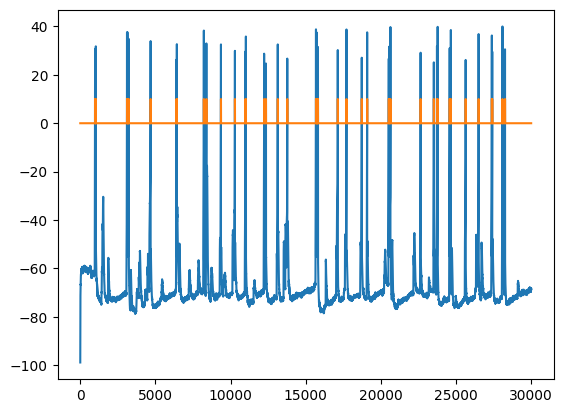

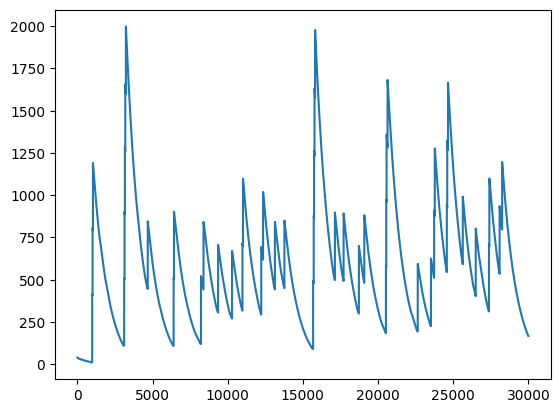

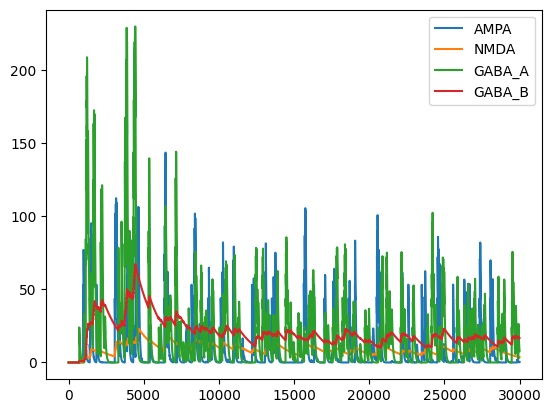

In [381]:
# Plot spikes for one neuron
n_idx = 101
t_first = 0
t_last = -1
plt.plot(np.array(sim.stats.Vs)[t_first:t_last,n_idx])
plt.plot(np.array(sim.stats.spikes)[t_first:t_last,n_idx] * 10)
plt.show()
plt.plot(np.array(sim.stats.us)[t_first:t_last,n_idx])
plt.show()
plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
plt.legend()
plt.show()

In [382]:
# plt.plot(np.array(sim.debug_logger.s_ampa)[t_first:t_last,n_idx], label="AMPA")
# plt.plot(np.array(sim.debug_logger.s_nmda)[t_first:t_last,n_idx], label="NMDA")
# plt.plot(np.array(sim.debug_logger.s_gaba_a)[t_first:t_last,n_idx], label="GABA_A")
# plt.plot(np.array(sim.debug_logger.s_gaba_b)[t_first:t_last,n_idx], label="GABA_B")
# plt.legend()
# plt.show()

In [383]:
# connectome.compute_metrics(small_world=False)